In [1]:
lat, lon = -35.0862034,149.4188002 # lake george

In [2]:
import datacube

In [4]:
sarcube = datacube.Datacube(config={'db_hostname': 'agdcdev-db.nci.org.au',
                                    'db_port': 6432,
                                    'db_database': 'radar_test'})

In [20]:
#sarcube.list_products().name.to_list()
e = 0.1

In [10]:
data = sarcube.find_datasets(product='s1_gamma0_scene', lat=(lat+e,lat-e), lon=(lon+e,lon-e))

In [12]:
len(data)

192

In [22]:
data = sarcube.load(product='s1_gamma0_scene', lat=(lat+e,lat-e), lon=(lon+e,lon-e))

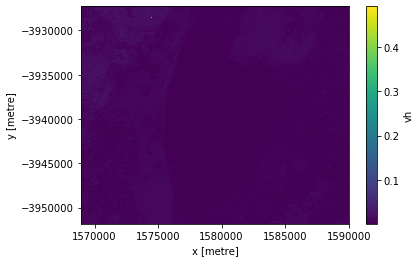

In [23]:
data.vh.mean(dim='time').plot()